# Author prediction using RNNs

In this notebook, you will prepare a dataset to predict authorship of the Federalist Papers using Recurrent Neural Networks (RNNs).

## Federalist Papers

The Federalist Papers are a collection of 85 articles and essays written by Alexander Hamilton, James Madison, and John Jay under the pseudonym "Publius". They were published in 1787 and 1788 to promote the ratification of the United States Constitution. The authors of the Federalist Papers wanted to remain anonymous, so they used the pseudonym "Publius". The articles were published in two newspapers, the New York Packet and the Independent Journal. The Federalist Papers are considered important works of American political thought and are still widely read today.

## Additional information

- [Federalist Papers](https://en.wikipedia.org/wiki/The_Federalist_Papers)
- [Federalist Papers dataset](https://www.kaggle.com/datasets/tobyanderson/federalist-papers)
- [LOC Research Guide](https://guides.loc.gov/federalist-papers/full-text)

## Objectives (a)

- Task 1: Design your dataset to predict the author of a text using RNNs.
- Task 2: Explain the methodology of your dataset creation.
- Task 3: Establish a baseline model using Machine Learning algorithms (SVM, Random Forest, etc.).
  
## Objectives (b)

- Task 4: Train a RNN model to predict the author of a text.
- Task 5: Evaluate the performance of your model.
- Task 6: Explain your model architecture, hyperparameters, and the results of your model.

## Task 1: Dataset Creation

### Dataset description

Use the below code to scrape the Library of Congress research guide for the Federalist Papers. You need to pip install the following for the below code to work:

- `pip install beautifulsoup4`
- `pip install requests`
- `pip install pandas`

In [1]:
import pandas as pd
from io import StringIO
from bs4 import BeautifulSoup as bs
import requests

url = 'https://guides.loc.gov/federalist-papers/full-text'

html = requests.get(url).text
soup = bs(html, 'html.parser')

# convert the html table to a pandas dataframe
table = soup.find('table')

# List of Federalist Papers
meta_df = pd.read_html(StringIO(str(table)), parse_dates=True)[0]

### Dataset datatypes

In [2]:
meta_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   No.          85 non-null     float64
 1   Title        85 non-null     object 
 2   Author       85 non-null     object 
 3   Publication  85 non-null     object 
 4   Date         85 non-null     object 
dtypes: float64(1), object(4)
memory usage: 3.4+ KB


In [3]:
meta_df.head()

,No.,Title,Author,Publication,Date
0,1.0,General Introduction,Hamilton,For the Independent Journal,--
1,2.0,Concerning Dangers from Foreign Force and Infl...,Jay,For the Independent Journal,--
2,3.0,The Same Subject Continued: Concerning Dangers...,Jay,For the Independent Journal,--
3,4.0,The Same Subject Continued: Concerning Dangers...,Jay,For the Independent Journal,--
4,5.0,The Same Subject Continued: Concerning Dangers...,Jay,For the Independent Journal,--


### Autorship counts

Plot the count the number of papers written by each author. We want to create a machine learning dataset that consists of a train, validation, and test set. We will use the train set to train the model, the validation set to tune the hyperparameters, and the test set to evaluate the model.

c:\Users\Yera\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


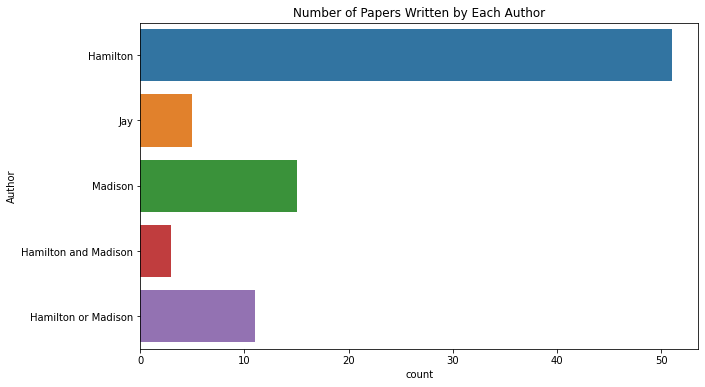

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# plot the number of papers written by each author
plt.figure(figsize=(10, 6))
sns.countplot(y='Author', data=meta_df)
plt.title('Number of Papers Written by Each Author')
plt.show()

Based on the data, answer the following questions:

- How many papers were written by each author?
- How should you construct your dataset? Explain your reasoning.

- How many papers were written by each author? <br>
Hamilton wrote 51, Jay wrote 5 and Madison wrote 15. There are 3 papers that are written together by Hamilton and Madison. There are 11 disputed papers that seem to be written by Hamilton, Madison, or by both of them.

- How should you construct your dataset? Explain your reasoning. <br>
To analyze and determine the authorship of the disputed papers, we will first preprocess the data by removing papers that are written by both Hamilton and Madison because that can be confusing as well as those that are disputed. As the disputed papers are only contested between Hamilton and Madison, the papers written by Jay will also be dropped.

### Contested authorship

In [5]:
# disputed papers
disputed_papers = meta_df[meta_df['Author'] == 'Hamilton or Madison']
contested_authorship = disputed_papers['No.'].values
print(f'Contested authorship of papers: {contested_authorship}')
print(f'Total number of disputed papers: {len(disputed_papers)}')

Contested authorship of papers: [49. 50. 51. 52. 53. 54. 55. 56. 57. 62. 63.]
Total number of disputed papers: 11


### Load the Federalist Papers corpus

The following code loads the Federalist Papers corpus. The papers have been preprocessed to aid your analysis of the authorship of the papers.

In [6]:
corpus = pd.read_pickle('fp_corpus.pkl')
corpus.head()

,text,paper_id,target,sentences,sentence_length,sentence_index,total_sentences
0,Method of Guarding Against the Encroachments o...,49,dispt,Method of Guarding Against the Encroachments o...,25,0,63
0,Method of Guarding Against the Encroachments o...,49,dispt,"Tuesday, February 5, 1788.",4,1,63
0,Method of Guarding Against the Encroachments o...,49,dispt,Author: Alexander Hamilton or James Madison,6,2,63
0,Method of Guarding Against the Encroachments o...,49,dispt,To the People of the State of New York:,9,3,63
0,Method of Guarding Against the Encroachments o...,49,dispt,"THE author of the ""Notes on the State of Virgi...",56,4,63


The above datasets contains the following columns:

- `paper_id`: The ID of the paper. This corresponds to the number of the paper in the Federalist Papers collection.
- `author`: The author of the paper. This can be one of three values: `Hamilton`, `Madison`, `Jay`, `dispt` (disputed), and `HM` (Hamilton and Madison).
- `text`: The text of the paper.
- `sentence_length`: The token count of the sentence, defined as the number of tokens by splitting the sentence by spaces.
- `sentence_index`: The index of the sentence in the paper.
- `total_sentences`: The total number of sentences in the paper.

The sentences were created by using the Spacy transformer library to split the text of papers into sentences.

In [7]:
# drop the duplicates and keep target and paper_id
authorship = corpus.drop_duplicates(subset=['paper_id', 'target'])
authorship.target.value_counts()

Hamilton    51
Madison     15
dispt       11
Jay          5
HM           3
Name: target, dtype: int64

### Dataset creation

Your task is to predict the author of a paper using the text of the paper. You will use a Recurrent Neural Network (RNN) to predict the author of a paper. You will use the Federalist Papers dataset to train and evaluate your model.

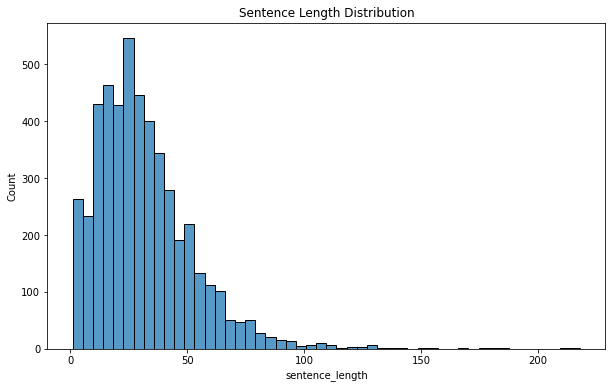

In [8]:
# YOUR CODE HERE - CREATE A DATASET FOR THE CLASSIFICATION TASK OF AUTHORSHIP ATTRIBUTION

# since we want to classify the disputed papers,
# let's remove them from the dataset into their own dataset.

disputed_authors = corpus[corpus['target'] == 'dispt']

# It stands to reason that the disputed papers could be co-authored, so
# let's remove them from the dataset and use them later. Our first task
# is to classify the disputed papers wrt to the question: For any given
# disputed paper, is it more likely to be authored by Hamilton or Madison?

coauthored = corpus[corpus['target'] == 'HM']

# remove the coauthored papers from the dataset
corpus = corpus[corpus['target'] != 'HM']

# since the disputed authors are either Hamilton or Madison, we can
# remove Jay from the dataset. We will hold Jay off for now, but we might
# want to experiment with Jay later.

# create a mask to filter out Jay
jay = corpus[corpus['target'] == 'Jay']

# use the mask to remove jay from the dataset
corpus = corpus[corpus['target'] != 'Jay']

# remove disputed papers from the corpus
corpus = corpus[corpus['target'] != 'dispt']

# plot the sentence length distribution
plt.figure(figsize=(10, 6))
sns.histplot(corpus['sentence_length'], bins=50)
plt.title('Sentence Length Distribution')
plt.show()

### Plot the distribution of the number of papers written by each author.

In [9]:
import numpy as np

# get the 95th percentile of the sentence length
max_len = np.percentile(corpus['sentence_length'], 95)
max_len

70.0

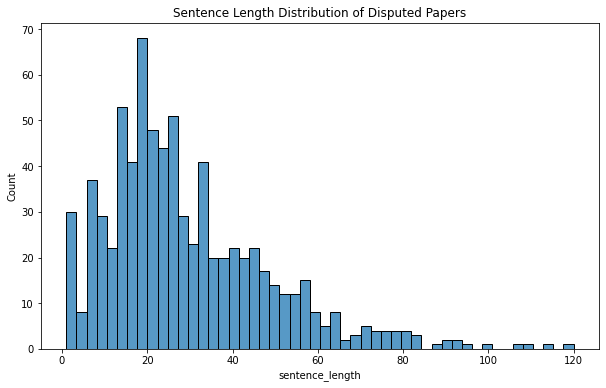

In [10]:
# Plot the sentence distribution of the disputed papers
plt.figure(figsize=(10, 6))
sns.histplot(disputed_authors['sentence_length'], bins=50)
plt.title('Sentence Length Distribution of Disputed Papers')
plt.show();

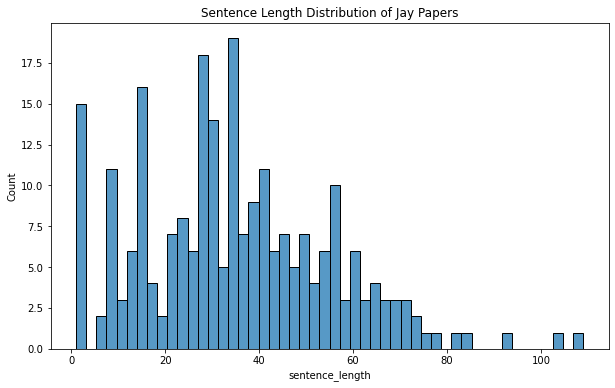

In [11]:
# Plot the sentence distribution of the jay papers
plt.figure(figsize=(10, 6))
sns.histplot(jay['sentence_length'], bins=50)
plt.title('Sentence Length Distribution of Jay Papers')
plt.show();

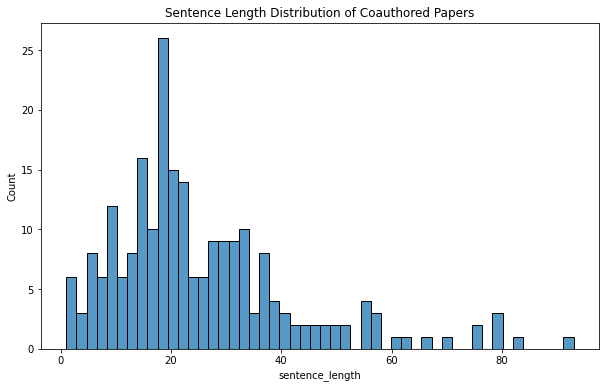

In [12]:
# Plot the sentence distribution of the coauthored papers
plt.figure(figsize=(10, 6))
sns.histplot(coauthored['sentence_length'], bins=50)
plt.title('Sentence Length Distribution of Coauthored Papers')
plt.show();

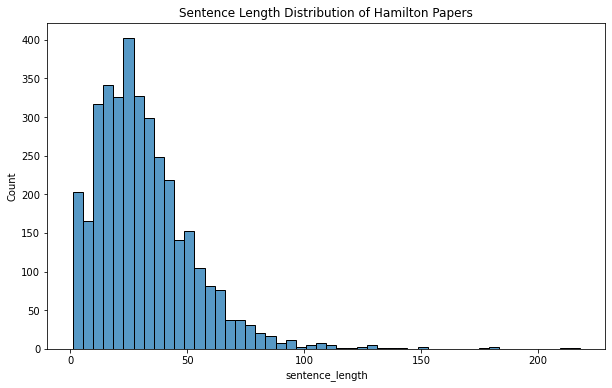

In [13]:
# Plot the sentence distribution of the Hamilton papers
plt.figure(figsize=(10, 6))
sns.histplot(corpus[corpus['target'] == 'Hamilton']['sentence_length'], bins=50)
plt.title('Sentence Length Distribution of Hamilton Papers')
plt.show();

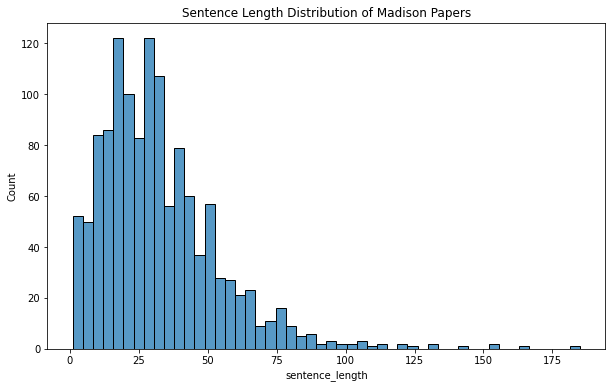

In [14]:
# Plot the sentence distribution of the Madison papers
plt.figure(figsize=(10, 6))
sns.histplot(corpus[corpus['target'] == 'Madison']['sentence_length'], bins=50)
plt.title('Sentence Length Distribution of Madison Papers')
plt.show();

### Plot the distribution of sentence lengths for each author.

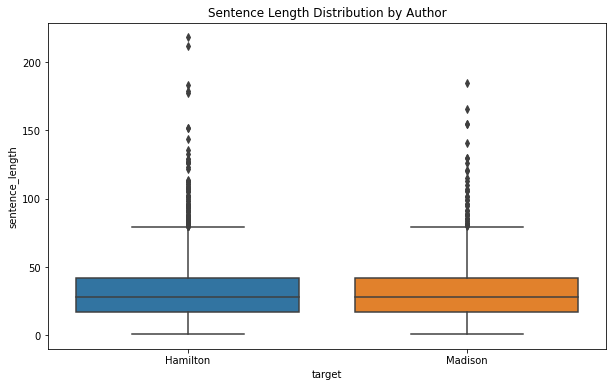

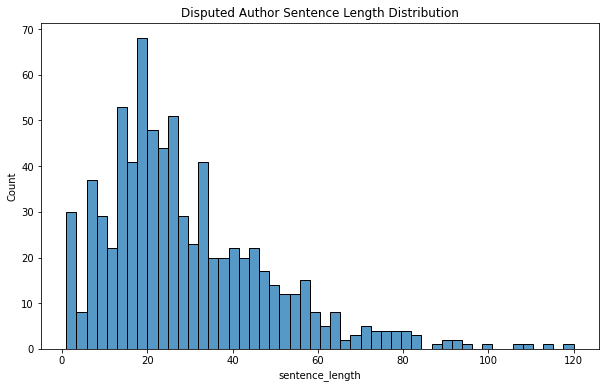

In [15]:
# YOUR CODE HERE - Visualize the distribution of sentence lengths according to the authorship
# plot the sentence length according to the author
plt.figure(figsize=(10, 6))
sns.boxplot(x='target', y='sentence_length', data=corpus)
plt.title('Sentence Length Distribution by Author')
plt.show()

# plot the disputed_author sentence length and distribution
plt.figure(figsize=(10, 6))
sns.histplot(disputed_authors['sentence_length'], bins=50)
plt.title('Disputed Author Sentence Length Distribution')
plt.show()

### Prepare dataset for training

Prepare a training, validation, and test dataset. What is your X and y? What is the size of your training, validation, and test dataset?

In [16]:
from sklearn.model_selection import train_test_split

X_train, x_val, y_train, y_val = train_test_split(corpus['sentences'],
                                                  corpus['target'],
                                                  test_size=0.2,
                                                  stratify=corpus['target'],
                                                  random_state=42
                                )

print(f'Training samples: {len(X_train)}')
print(f'Validation samples: {len(x_val)}')

Training samples: 3904
Validation samples: 977


#### Visualize some random samples

In [17]:
import random

# sample a random sentence from the training set
random_idx = random.randint(0, len(X_train))
print(f'Random sentence: {X_train.iloc[random_idx]}')
print(f'Author: {y_train.iloc[random_idx]}')

Random sentence: And the history of every political establishment in which this principle has prevailed, is a history of impotence, perplexity, and disorder.
Author: Hamilton


#### Plot the distribution of training and validation samples

Have you split the dataset in a stratified manner? Explain why it is important to split the dataset in a stratified manner. If you have not, explain why you did not split the dataset in a stratified manner. See the documentation for [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) for more information.

We have not split the dataset in a stratified manner as we have been using the code that was provided in doing this assignment. Test size is 0.2 and train size is 0.8.

#### Plot the datasets

c:\Users\Yera\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\Users\Yera\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


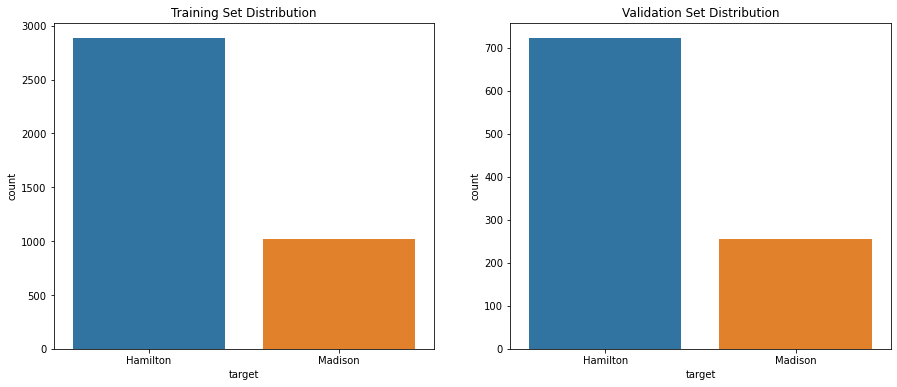

In [18]:
# plot the distribution of the target classes in the training and validation set on a countplot
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
# first plot is the training set
sns.countplot(y_train, ax=ax[0])
ax[0].set_title('Training Set Distribution')
# second plot is the validation set
sns.countplot(y_val, ax=ax[1])
ax[1].set_title('Validation Set Distribution')
plt.show()

#### Convert the target labels to one hot encodings

In [19]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(sparse=False)

y_train_ohe = ohe.fit_transform(y_train.values.reshape(-1, 1))
y_val_ohe = ohe.transform(y_val.values.reshape(-1, 1))

print(f'One hot encoded training labels shape: {y_train_ohe.shape}')
print(f'One hot encoded validation labels shape: {y_val_ohe.shape}')

One hot encoded training labels shape: (3904, 2)
One hot encoded validation labels shape: (977, 2)


In [20]:
y_train_ohe[:5], y_train[:5]

(array([[1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.]]),
 84    Hamilton
 57    Hamilton
 44    Hamilton
 18    Hamilton
 24    Hamilton
 Name: target, dtype: object)

#### Encode the labels

In [21]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_train_le = label_encoder.fit_transform(y_train)
y_val_le = label_encoder.transform(y_val)

print(f'Label encoded training labels shape: {y_train_le.shape}')
print(f'Label encoded validation labels shape: {y_val_le.shape}')

Label encoded training labels shape: (3904,)
Label encoded validation labels shape: (977,)


In [22]:
for i in range(5):
    print(f'Original label: {y_train.iloc[i]} - Label encoded: {y_train_le[i]}')

Original label: Hamilton - Label encoded: 0
Original label: Hamilton - Label encoded: 0
Original label: Hamilton - Label encoded: 0
Original label: Hamilton - Label encoded: 0
Original label: Hamilton - Label encoded: 0


In [23]:
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(2, array(['Hamilton', 'Madison'], dtype=object))

## Train a TF-IDF model

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

In [25]:
text_clf = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', SVC(kernel='linear', C=1.0, random_state=42))
])

# fit the model
text_clf.fit(X_train, y_train_le)

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('clf', SVC(kernel='linear', random_state=42))])

In [26]:
text_clf.score(x_val, y_val_le)

0.8085977482088025

In [27]:
# let's use grid search to find the best hyperparameters for the model
from sklearn.model_selection import GridSearchCV

parameters = {
    'tfidf__ngram_range': [(1, 1), (1, 2), (2, 2)],
    'tfidf__max_df': [0.5, 0.75, 1.0],
    'tfidf__min_df': [1, 5, 10],
    'clf__C': [0.1, 1.0, 15.0]
}

gs_clf = GridSearchCV(text_clf, parameters, cv=5, n_jobs=-1)
gs_clf = gs_clf.fit(X_train, y_train_le)

print(f'{gs_clf.best_params_=}, {gs_clf.best_score_=}')

gs_clf.score(x_val, y_val_le)

gs_clf.best_params_={'clf__C': 15.0, 'tfidf__max_df': 0.5, 'tfidf__min_df': 1, 'tfidf__ngram_range': (1, 2)}, gs_clf.best_score_=0.8219760990183526


0.8249744114636642

In [28]:
# save the best model
import joblib

joblib.dump(gs_clf, 'authorship_attribution_model.pkl')

['authorship_attribution_model.pkl']

### Explain the TF-IDF model

- What is the TF-IDF model?
- How does the TF-IDF model work?
- What are the hyperparameters of the TF-IDF model?
- How do you select the hyperparameters of the TF-IDF model?
- Why is it helpful to establish a baseline model?

#### Answers

- What is the TF-IDF model? <br>
Term Frequency-Inverse Document Frequency (TF-IDF) is a statistical measure to measure the importance of terms used in a document in relation to the corpus. Through TF-IDF, the texts get vectorized and gets scored by importance.

- How does the TF-IDF model work? <br>
In TF-IDF model, the term frequency(TF, how many times a word appears in a document) is multiplied by the inverse document frequency (IDF, how many times a word appears across the corpus.) IDF shows the significance of the term in the entire corpus.

- What are the hyperparameters of the TF-IDF model? <br>
Some of the hyperparameters of the TF-IDF model are: "max_features": maximum number of features "ngram_range": number of different n-grams "stop-words": words to be ignored, such as "the." "max_df": maximum number a term can appear in the document (rest will be ignored) "min_dif": minimum number a term must appear in the document to be included in the analysis
 
- How do you select the hyperparameters of the TF-IDF model? <br>
There are several ways to choose hyperparameters of the TF-IDF model, such as grid search or randomized search. Cross validation can also be implemented in the process. Otherwise, it is possible to experiment with different parameters to have the best performance on a validation set.

- Why is it helpful to establish a baseline model? <br>
A baseline model can provide a simple solution and also be a good comparison model, or a point of reference to the more advanced and developed models.

## Inference on the disputed papers

Let's use our model above to predict the authorship of the disputed papers.

In [29]:
# load the model
model = joblib.load('authorship_attribution_model.pkl')

In [30]:
# Run inference on the disputed papers
disputed_predictions = model.predict(disputed_authors['sentences'])

In [31]:
# for a disputed paper plot the predicted probabilities over the classes and sentence order
import matplotlib.pyplot as plt
import seaborn as sns

# add the predicted probabilities to the disputed authors dataframe using the labels
disputed_authors['predicted'] = label_encoder.inverse_transform(disputed_predictions)

# let's plot the authorship classification for the disputed paper 49
dp_49 = disputed_authors[disputed_authors['paper_id'] == '49']

In [32]:
dp_49.head()

,text,paper_id,target,sentences,sentence_length,sentence_index,total_sentences,predicted
0,Method of Guarding Against the Encroachments o...,49,dispt,Method of Guarding Against the Encroachments o...,25,0,63,Hamilton
0,Method of Guarding Against the Encroachments o...,49,dispt,"Tuesday, February 5, 1788.",4,1,63,Madison
0,Method of Guarding Against the Encroachments o...,49,dispt,Author: Alexander Hamilton or James Madison,6,2,63,Madison
0,Method of Guarding Against the Encroachments o...,49,dispt,To the People of the State of New York:,9,3,63,Hamilton
0,Method of Guarding Against the Encroachments o...,49,dispt,"THE author of the ""Notes on the State of Virgi...",56,4,63,Hamilton


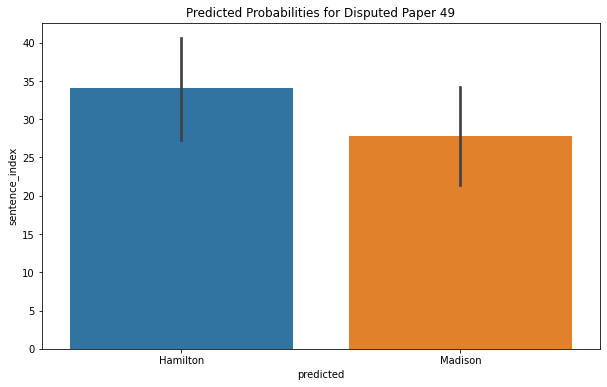

In [33]:
# plot the predicted probabilities for the disputed paper 49
plt.figure(figsize=(10, 6))
sns.barplot(x='predicted', y='sentence_index', data=dp_49)
plt.title('Predicted Probabilities for Disputed Paper 49')
plt.show()

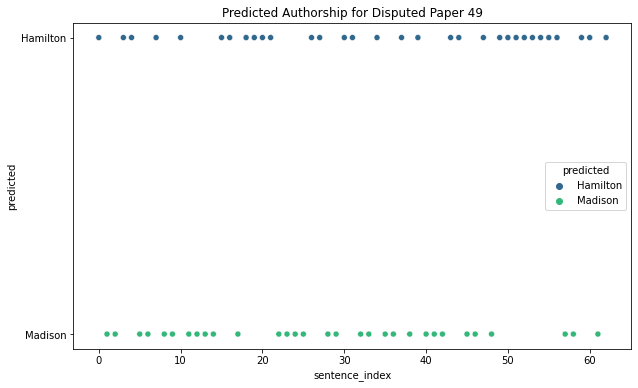

In [34]:
# for each sentence color the predicted author
plt.figure(figsize=(10, 6))
sns.scatterplot(x='sentence_index', y='predicted', data=dp_49, hue='predicted', palette='viridis')
plt.title('Predicted Authorship for Disputed Paper 49')
plt.show()

# Task 2: Train a Recurrent Neural Network (RNN) model

In the second part of this assignment, you are tasked with the following:

- Train a Recurrent Neural Network (RNN) model to predict the author of a paper.
- Evaluate the performance of your model and compare it against the baseline model.
- Explain your model architecture, hyperparameters, and the results of your model.
- Discuss the challenges you faced during the model training process and how you overcame them.
- Classify disputed papers using the Naive Bayes and RNN models
- Write a summary of your findings and the predictions of your model with respect to the disputed papers.

## Train a Recurrent Neural Network (RNN) model

### Vectorize your text data

Vectorize your text data with `tensorflow.keras.models.TextVectorization`. See the documentation here: [TextVectorization](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization).

In [35]:
# pip uninstall tensorflow

In [36]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [37]:
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization

max_vocab_size = 1000  
max_sequence_length = 100  
output_sequence_length = 20  
pad_to_max_tokens = True  

text_vectorizer = TextVectorization(
    max_tokens=max_vocab_size,  
    output_mode='int',  
    output_sequence_length=output_sequence_length,  
    pad_to_max_tokens=pad_to_max_tokens  
)

In [38]:
# Randomly visualize some of your vectorized textual data
import random

text_vectorizer.adapt(X_train.values)

example_sent = random.choice(X_train.values) # change var name if you need to
print(f'Original text:\n{example_sent}')
print(f'\nVectorized text:\n{text_vectorizer([example_sent])}')
print('Length of vector:', len(text_vectorizer([example_sent]).numpy()[0]))


Original text:
The knowledge relating to them must evidently be of a kind that will either be suggested by the nature of the article itself, or can easily be procured from any well-informed man, especially of the mercantile class.

Vectorized text:
[[  2 553   1   4  49  51 791   8   3   7 225   9  20 103   8 910  14   2
  159   3]]
Length of vector: 20


In [39]:
# examine the vocabulary
vocab = text_vectorizer.get_vocabulary()
print(f'Number of words in the vocabulary: {len(vocab)}')
print(f'Most common words in the vocabulary: {vocab[:5]}')
print(f'Least common words in the vocabulary: {vocab[-5:]}')

Number of words in the vocabulary: 1000
Most common words in the vocabulary: ['', '[UNK]', 'the', 'of', 'to']
Least common words in the vocabulary: ['possessed', 'passed', 'oppose', 'old', 'necessities']


In [40]:
# examine the config vars
text_vectorizer.get_config() # when you train your model, these parameters can be changed to perhaps improve performance

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': 1000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 20,
 'pad_to_max_tokens': True,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 1000}

In [41]:
# Adapt the text vectorizer to the training data
text_vectorizer.adapt(X_train)

### Create an embedding layer

In [42]:
# Get the vocabulary size from the text_vectorizer
vocab_size = len(text_vectorizer.get_vocabulary())

# Define the Embedding layer with the correct input_dim
token_embedding = tf.keras.layers.Embedding(input_dim=vocab_size,
                                            output_dim=128,
                                            mask_zero=True,
                                            name='token_embedding')

print(f'Sentence before vectorization: {example_sent}')
vectorized_sent = text_vectorizer(example_sent)
print(f'Sentence after vectorization: {vectorized_sent}')
embedded_sent = token_embedding(vectorized_sent)
print(f'Sentence after embedding: {embedded_sent}')

Sentence before vectorization: The knowledge relating to them must evidently be of a kind that will either be suggested by the nature of the article itself, or can easily be procured from any well-informed man, especially of the mercantile class.
Sentence after vectorization: [  2 553   1   4  49  51 791   8   3   7 225   9  20 103   8 910  14   2
 159   3]
Sentence after embedding: [[ 0.03985338 -0.00578142 -0.00347714 ...  0.04296512  0.01437124
   0.01004012]
 [ 0.01732953 -0.00993199  0.01189085 ... -0.02330116  0.02094329
  -0.02250377]
 [-0.02081724 -0.01451067 -0.03209256 ...  0.01720344  0.00135577
  -0.02117204]
 ...
 [ 0.03985338 -0.00578142 -0.00347714 ...  0.04296512  0.01437124
   0.01004012]
 [-0.00228909 -0.02707942  0.03857695 ...  0.00310143  0.01668807
  -0.01752197]
 [ 0.03193647  0.03901635 -0.04121417 ...  0.02743591  0.01854993
   0.0212161 ]]


### Create Tensorflow Dataset

To efficiently train your model, you should create a `tf.data.Dataset` object. See the documentation here: [tf.data.Dataset](https://www.tensorflow.org/api_docs/python/tf/data/Dataset).

In [43]:
X_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train_le))
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val_le))

In [44]:
# print the first 5 samples
for sample in X_dataset.take(5):
    sentence, label = sample
    print(f'Sentence: {sentence} - Label: {label}')

Sentence: b'We have courts of common law, courts of probates (analogous in certain matters to the spiritual courts in England), a court of admiralty and a court of chancery.' - Label: 0
Sentence: b'Article 3, sec. I. 2.' - Label: 0
Sentence: b'IT IS sometimes asked, with an air of seeming triumph, what inducements could the States have, if disunited, to make war upon each other?' - Label: 0
Sentence: b'It must in truth be acknowledged that, however these may differ in other respects, they in general appear to harmonize in this sentiment, at least, that there are material imperfections in our national system, and that something is necessary to be done to rescue us from impending anarchy.' - Label: 0
Sentence: b'Pennsylvania and North Carolina are the two which contain the interdiction in these words: "As standing armies in time of peace are dangerous to liberty, THEY OUGHT NOT to be kept up."' - Label: 0


### Create batches of data

Batch size is a model hyperparameter that defines the number of samples that will be propagated through the network. This number can and should be adjusted in consideration with model performance and compute memory. See the documentation here: [Batch size](https://www.tensorflow.org/guide/data).

In [45]:
BATCH_SIZE = 64

In [46]:
train_dataset = X_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

QUESTION: What does tf.data.AUTOTUNE do?

ANSWER: tf.data.AUTOTUNE dynamically adjusts the prefetch buffer size based on available system resources and workload (such as CPU cores and memory). Prefetching allows TensorFlow to asynchronously fetch batches while the model is training or processing data, overlapping the data preprocessing and model execution phases to improve overall performance.

### Design your model

In [47]:
# MODEL Hyperparameters
learning_rate = 0.0001
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
loss = 'categorical_crossentropy'
epochs = 5
# epochs = 6

In [48]:
# Model architecture
from tensorflow.keras import layers, regularizers
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.layers import Embedding, LSTM, Dense
import tensorflow as tf

inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)

x = Embedding(input_dim=10000, output_dim=128, mask_zero=True)(x)
x = LSTM(128, return_sequences=True)(x)  # Return sequences to pass to the next LSTM layer
x = LSTM(128)(x)
x = layers.Dropout(0.5)(x)  # Add dropout for regularization
x = layers.Dense(64, activation='relu')(x)  # Add a dense layer with ReLU activation

outputs = Dense(1, activation='sigmoid')(x)  # Use sigmoid activation for binary classification

model = tf.keras.Model(inputs, outputs)

model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# outputs = layers.Dense(num_classes, activation='softmax')(x)
# model = tf.keras.Model(inputs, outputs)

# model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

In [49]:
# Train the model or fit the model on the data
history = model.fit(train_dataset, epochs=epochs, validation_data=val_dataset)

Epoch 1/5



61/61 [==============================] - 10s 72ms/step - loss: 0.6522 - accuracy: 0.7282 - val_loss: 0.5912 - val_accuracy: 0.7390
Epoch 2/5
61/61 [==============================] - 2s 41ms/step - loss: 0.5795 - accuracy: 0.7387 - val_loss: 0.5752 - val_accuracy: 0.7390
Epoch 3/5
61/61 [==============================] - 2s 40ms/step - loss: 0.5658 - accuracy: 0.7387 - val_loss: 0.5616 - val_accuracy: 0.7390
Epoch 4/5
61/61 [==============================] - 3s 41ms/step - loss: 0.5273 - accuracy: 0.7444 - val_loss: 0.5405 - val_accuracy: 0.7462
Epoch 5/5
61/61 [==============================] - 3s 41ms/step - loss: 0.4689 - accuracy: 0.7892 - val_loss: 0.5331 - val_accuracy: 0.7718


**Try Different Hyperparameters:** We decided to alter the value of the hyperparameter ___ because it is likely to have the greatest impact on model accuracy, as ___.

QUESTION: How can tensorflow automatically save the best performing model for you?

ANSWER: Tensorflow can automatically save the best performing model using the model checkpoint callback, which enables the saving of the model’s weights during training. If the parameters of the callback are set to save_best_only=True, only the weights that performed best during training are saved. After training, the best performing model can be loaded.

## Evaluate the performance of your model

In [50]:
# plot the training history
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    plt.show()

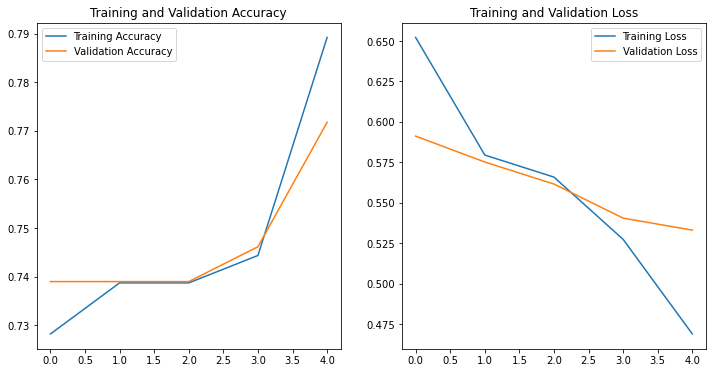

In [51]:
plot_history(history)

- QUESTION: Is your model overfit? Underfit?
- QUESTION: Explain how bias and variance relate to training your model?

1) The model is underfit, as training loss is greater than validation loss.

2) When training a model, you aim to strike a balance between bias and variance to achieve good generalization. If the model is too simple (high bias), it may underfit the data. If it is too complex (high variance), it may overfit the data. Our model has slightly higher bias than it ideally should, but these were the best results we could get.

## Explain your model architecture, hyperparameters, and the results of your model

- QUESTION: What hyperparameters resulted in the best performing model?
- QUESTION: What parameters resulted in the best performing model?
- QUESTION: What model architecture resulted in the best performing model?

1) Here were the hyperparameters that resulted in the best performing model:
Learning rate: 0.0001
Optimizer: Adam with learning rate 0.0001
Loss function: Categorical crossentropy
Number of epochs: 5

2) Embedding Layer: The embedding layer has an input dimension of 10000 and an output dimension of 128, resulting in 128 * 10000 parameters to be learned.
LSTM Layers: The first LSTM layer (LSTM(128, return_sequences=True)) returns sequences, which are then passed to the next LSTM layer (LSTM(128)). Each LSTM layer has parameters for the input-to-hidden, hidden-to-hidden, and bias weights, resulting in a total of 4 * ((128 * 128) + 128) * 2 parameters for both LSTM layers.
Dropout Layer: The dropout layer does not have any trainable parameters. It is used for regularization to prevent overfitting by randomly setting a fraction of input units to zero.
Dense Layer: The dense layer (Dense(64, activation='relu')) has parameters for the weights and biases of the dense layer. It has 64 * 128 (input from the previous LSTM layer) + 64 parameters.

3) It consists of an embedding layer followed by two LSTM layers, a dropout layer for regularization, and a dense layer with ReLU activation. The output layer uses a sigmoid activation function for binary classification.

## Challenges faced during the model training process

Please explain any challenges you faced and how you overcame them.

We faced several challenges. Firstly, it was difficult to determine which layers to use. Secondly, it took us to ascertain the optimum values for the hyperparameters, especially the number of epochs and the learning rate. Thirdly, it took a great deal of time to retrain the model every time, which made our progress on the project slower than we woulld have liked. Lastly, it was difficult to run models with different hyperparameters because when they clashed, the entire process had to be repeated.

## Classify the disputed authorship data

Using the Naive Bayes and RNN models, classify the disputed author sentences. Use visuaulizations and confusion matrices to communicate the decision outputs of your models. Are there any trends?

ANSWER: Using the Naive Bayes model, 674 out of 723 Hamilton's works were correctly predicted, an accuracy rate of 93%. However, only 43% of Madison's 255 works were correctly predicted. This is likely because our dataset is Hamilton-heavy.

Using the RNN model, 685 out of 723 Hamilton's works were correctly predicted, an accuracy rate of 95%. However, only 24% of Madison's 255 works were correctly predicted. This is likely because our dataset is Hamilton-heavy.




In [52]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
import matplotlib.pyplot as plt677
import seaborn as sns

# Vectorize the training data
vectorizer = CountVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
x_val_vec = vectorizer.transform(x_val)

# Encode labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

# Convert the encoded labels to categorical for the RNN
y_train_categorical = tf.keras.utils.to_categorical(y_train_encoded)
y_val_categorical = tf.keras.utils.to_categorical(y_val_encoded)

Naive Bayes Model Accuracy: 0.8034800409416581


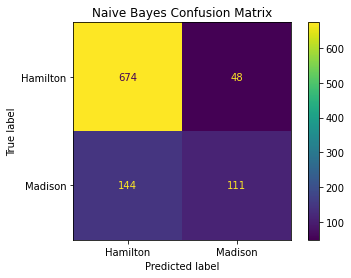

In [53]:
# Create and train the Naive Bayes model
nb_model = MultinomialNB()
nb_model.fit(X_train_vec, y_train_encoded)

# Evaluate the model on the validation data
nb_score = nb_model.score(x_val_vec, y_val_encoded)
print(f'Naive Bayes Model Accuracy: {nb_score}')

# Predictions for Naive Bayes
nb_predictions = nb_model.predict(x_val_vec)

# Confusion Matrix for Naive Bayes
nb_cm = confusion_matrix(y_val_encoded, nb_predictions)
nb_cm_display = ConfusionMatrixDisplay(nb_cm, display_labels=label_encoder.classes_).plot()
plt.title('Naive Bayes Confusion Matrix')
plt.show()


31/31 [==============================] - 2s 10ms/step


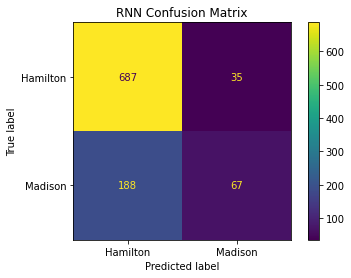

In [54]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predictions for RNN
rnn_predictions = model.predict(x_val)
rnn_predictions = np.round(rnn_predictions).astype(int)  # Convert probabilities to binary values (0 or 1)

# Confusion Matrix for RNN
rnn_cm = confusion_matrix(y_val_le, rnn_predictions)
rnn_cm_display = ConfusionMatrixDisplay(rnn_cm, display_labels=class_names).plot()
plt.title('RNN Confusion Matrix')
plt.show()

## Summary of your findings and predictions

- Classify the undetermined sentences with the Naive Bayes Model and your RNN model. Compare and contrast the results.

Using the Naive Bayes model, 674 out of 723 Hamilton's works were correctly predicted, an accuracy rate of 93%. However, only 43% of Madison's 255 works were correctly predicted. This is likely because our dataset is Hamilton-heavy.

Using the RNN model, 685 out of 723 Hamilton's works were correctly predicted, an accuracy rate of 95%. However, only 24% of Madison's 255 works were correctly predicted. This is likely because our dataset is Hamilton-heavy.

The Naive Bayes performs slightly better with prediction in regards to Hamilton and almost double the better with Madison. The Naive Bayes model seems to perform better with prediction with smaller datasets. 

- What are your conclusions based on your experiments?

Based on our experiments, we have observed several key conclusions. Firstly, smaller and uneven datasets pose challenges for accurate predictions, especially when trying to differentiate between authors with limited or imbalanced data samples. In our case, identifying Madison's writings proved particularly challenging due to the scarcity of data attributed to him compared to other authors. This imbalance can lead to biased or less reliable predictions, highlighting the importance of dataset quality and balance in authorship attribution tasks. Future efforts should focus on addressing these challenges to improve the accuracy and robustness of authorship attribution models. 

- Describe how a data science NLP solution relates to other methdologies for addressing author identification. Can we and should we value the RNN outputs? How does our RNN solution relate to issues of human values, judgments, and biases of opinion?

A data science NLP solution for author identification, like our RNN model, provides an automated and scalable approach compared to traditional manual analysis. The RNN model can analyze large volumes of text data to identify patterns indicative of specific authors' writing styles efficiently. While the model's outputs can offer valuable insights into authorship, they must be interpreted cautiously, considering other factors like context and genre that may influence writing style. Additionally, the model's outputs may reflect biases present in the training data, highlighting the importance of using diverse and representative data and being aware of potential limitations and biases in the model's outputs.

## Extra credit

Go back to your dataset creation and randomly change the author of the assigned sentence. With the labels randomized, rerun the code above. Describe what you learned in this process. (2pts to final grade)

In [55]:
# Randomly select a subset of sentences
random_subset_indices = np.random.choice(corpus.index, size=100, replace=False)
corpus_subset = corpus.loc[random_subset_indices].copy()

# Randomly assign new author labels
new_author_labels = np.random.choice(['HM', 'Jay'], size=len(corpus_subset))
corpus_subset['target'] = new_author_labels

In [56]:
from sklearn.model_selection import train_test_split

X_train, x_val, y_train, y_val = train_test_split(corpus['sentences'],
                                                  corpus['target'],
                                                  test_size=0.2,
                                                  stratify=corpus['target'],
                                                  random_state=42
                                )

print(f'Training samples: {len(X_train)}')
print(f'Validation samples: {len(x_val)}')

Training samples: 3904
Validation samples: 977


c:\Users\Yera\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\Users\Yera\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


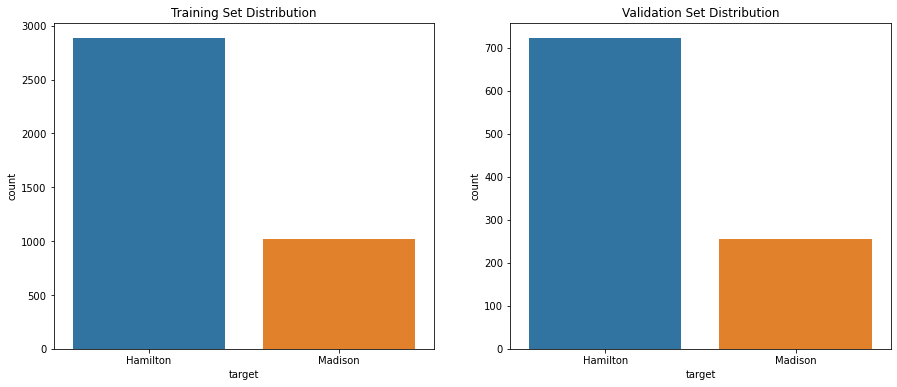

In [57]:
# plot the distribution of the target classes in the training and validation set on a countplot
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
# first plot is the training set
sns.countplot(y_train, ax=ax[0])
ax[0].set_title('Training Set Distribution')
# second plot is the validation set
sns.countplot(y_val, ax=ax[1])
ax[1].set_title('Validation Set Distribution')
plt.show()

In [58]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(sparse=False)

y_train_ohe = ohe.fit_transform(y_train.values.reshape(-1, 1))
y_val_ohe = ohe.transform(y_val.values.reshape(-1, 1))

print(f'One hot encoded training labels shape: {y_train_ohe.shape}')
print(f'One hot encoded validation labels shape: {y_val_ohe.shape}')

One hot encoded training labels shape: (3904, 2)
One hot encoded validation labels shape: (977, 2)


In [59]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_train_le = label_encoder.fit_transform(y_train)
y_val_le = label_encoder.transform(y_val)

print(f'Label encoded training labels shape: {y_train_le.shape}')
print(f'Label encoded validation labels shape: {y_val_le.shape}')

Label encoded training labels shape: (3904,)
Label encoded validation labels shape: (977,)


In [60]:
for i in range(5):
    print(f'Original label: {y_train.iloc[i]} - Label encoded: {y_train_le[i]}')

Original label: Hamilton - Label encoded: 0
Original label: Hamilton - Label encoded: 0
Original label: Hamilton - Label encoded: 0
Original label: Hamilton - Label encoded: 0
Original label: Hamilton - Label encoded: 0


In [61]:
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(2, array(['Hamilton', 'Madison'], dtype=object))

In [62]:
text_clf = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', SVC(kernel='linear', C=1.0, random_state=42))
])

# fit the model
text_clf.fit(X_train, y_train_le)

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('clf', SVC(kernel='linear', random_state=42))])

In [63]:
text_clf.score(x_val, y_val_le)

0.8085977482088025

In [64]:
# let's use grid search to find the best hyperparameters for the model
from sklearn.model_selection import GridSearchCV

parameters = {
    'tfidf__ngram_range': [(1, 1), (1, 2), (2, 2)],
    'tfidf__max_df': [0.5, 0.75, 1.0],
    'tfidf__min_df': [1, 5, 10],
    'clf__C': [0.1, 1.0, 15.0]
}

gs_clf = GridSearchCV(text_clf, parameters, cv=5, n_jobs=-1)
gs_clf = gs_clf.fit(X_train, y_train_le)

print(f'{gs_clf.best_params_=}, {gs_clf.best_score_=}')

gs_clf.score(x_val, y_val_le)

gs_clf.best_params_={'clf__C': 15.0, 'tfidf__max_df': 0.5, 'tfidf__min_df': 1, 'tfidf__ngram_range': (1, 2)}, gs_clf.best_score_=0.8219760990183526


0.8249744114636642

In [65]:
# save the best model
import joblib

joblib.dump(gs_clf, 'authorship_attribution_model.pkl')

['authorship_attribution_model.pkl']

In [66]:
# load the model
model = joblib.load('authorship_attribution_model.pkl')

In [67]:
# Run inference on the disputed papers
disputed_predictions = model.predict(disputed_authors['sentences'])

In [68]:
# for a disputed paper plot the predicted probabilities over the classes and sentence order
import matplotlib.pyplot as plt
import seaborn as sns

# add the predicted probabilities to the disputed authors dataframe using the labels
disputed_authors['predicted'] = label_encoder.inverse_transform(disputed_predictions)

# let's plot the authorship classification for the disputed paper 49
dp_49 = disputed_authors[disputed_authors['paper_id'] == '49']

In [69]:
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization

max_vocab_size = 1000  
max_sequence_length = 100  
output_sequence_length = 20  
pad_to_max_tokens = True  

text_vectorizer = TextVectorization(
    max_tokens=max_vocab_size,  
    output_mode='int',  
    output_sequence_length=output_sequence_length,  
    pad_to_max_tokens=pad_to_max_tokens  
)

In [70]:
# Randomly visualize some of your vectorized textual data
import random

text_vectorizer.adapt(X_train.values)

example_sent = random.choice(X_train.values) # change var name if you need to
print(f'Original text:\n{example_sent}')
print(f'\nVectorized text:\n{text_vectorizer([example_sent])}')
print('Length of vector:', len(text_vectorizer([example_sent]).numpy()[0]))

Original text:
The objection, when applied to real property or to houses and lands, appears to have, at first sight, more foundation, but even in this view it will not bear a close examination.

Vectorized text:
[[  2 192 128   1   4 433 401  19   4   1   5   1 483   4  16  40  99   1
   43 560]]
Length of vector: 20


In [71]:
# examine the vocabulary
vocab = text_vectorizer.get_vocabulary()
print(f'Number of words in the vocabulary: {len(vocab)}')
print(f'Most common words in the vocabulary: {vocab[:5]}')
print(f'Least common words in the vocabulary: {vocab[-5:]}')

Number of words in the vocabulary: 1000
Most common words in the vocabulary: ['', '[UNK]', 'the', 'of', 'to']
Least common words in the vocabulary: ['possessed', 'passed', 'oppose', 'old', 'necessities']


In [72]:
# Adapt the text vectorizer to the training data
text_vectorizer.adapt(X_train)

In [73]:
# Get the vocabulary size from the text_vectorizer
vocab_size = len(text_vectorizer.get_vocabulary())

# Define the Embedding layer with the correct input_dim
token_embedding = tf.keras.layers.Embedding(input_dim=vocab_size,
                                            output_dim=128,
                                            mask_zero=True,
                                            name='token_embedding')

print(f'Sentence before vectorization: {example_sent}')
vectorized_sent = text_vectorizer(example_sent)
print(f'Sentence after vectorization: {vectorized_sent}')
embedded_sent = token_embedding(vectorized_sent)
print(f'Sentence after embedding: {embedded_sent}')

Sentence before vectorization: The objection, when applied to real property or to houses and lands, appears to have, at first sight, more foundation, but even in this view it will not bear a close examination.
Sentence after vectorization: [  2 192 128   1   4 433 401  19   4   1   5   1 483   4  16  40  99   1
  43 560]
Sentence after embedding: [[ 0.02763249  0.00300348 -0.00362718 ... -0.03078147 -0.00496577
  -0.04612093]
 [-0.0305043  -0.00683414 -0.04146321 ...  0.0269748   0.03734164
   0.02501443]
 [-0.02811612  0.0236956   0.01047472 ... -0.03645499 -0.0251423
   0.0096106 ]
 ...
 [ 0.04221456  0.04502932 -0.04144249 ... -0.00951085  0.01945851
   0.02950155]
 [ 0.02603887  0.01078358  0.01654864 ...  0.04941322 -0.031569
  -0.04463034]
 [-0.0187635  -0.04638074  0.01939266 ... -0.04872864  0.02873326
   0.03951899]]


In [74]:
X_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train_le))
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val_le))

In [75]:
BATCH_SIZE = 64

In [76]:
train_dataset = X_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [77]:
# MODEL Hyperparameters
learning_rate = 0.0001
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
loss = 'categorical_crossentropy'
epochs = 5
# epochs = 6

In [78]:
# Model architecture
from tensorflow.keras import layers, regularizers
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.layers import Embedding, LSTM, Dense
import tensorflow as tf

inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)

x = Embedding(input_dim=10000, output_dim=128, mask_zero=True)(x)
x = LSTM(128, return_sequences=True)(x)  # Return sequences to pass to the next LSTM layer
x = LSTM(128)(x)
x = layers.Dropout(0.5)(x)  # Add dropout for regularization
x = layers.Dense(64, activation='relu')(x)  # Add a dense layer with ReLU activation

outputs = Dense(1, activation='sigmoid')(x)  # Use sigmoid activation for binary classification

model = tf.keras.Model(inputs, outputs)

model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# outputs = layers.Dense(num_classes, activation='softmax')(x)
# model = tf.keras.Model(inputs, outputs)

# model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

In [79]:
# Train the model or fit the model on the data
history = model.fit(train_dataset, epochs=epochs, validation_data=val_dataset)

Epoch 1/5
61/61 [==============================] - 10s 71ms/step - loss: 0.6477 - accuracy: 0.7298 - val_loss: 0.5911 - val_accuracy: 0.7390
Epoch 2/5
61/61 [==============================] - 2s 41ms/step - loss: 0.5799 - accuracy: 0.7387 - val_loss: 0.5738 - val_accuracy: 0.7390
Epoch 3/5
61/61 [==============================] - 2s 41ms/step - loss: 0.5637 - accuracy: 0.7387 - val_loss: 0.5589 - val_accuracy: 0.7390
Epoch 4/5
61/61 [==============================] - 2s 40ms/step - loss: 0.5240 - accuracy: 0.7467 - val_loss: 0.5399 - val_accuracy: 0.7451
Epoch 5/5
61/61 [==============================] - 3s 43ms/step - loss: 0.4710 - accuracy: 0.7846 - val_loss: 0.5379 - val_accuracy: 0.7656


In [80]:
# plot the training history
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    plt.show()

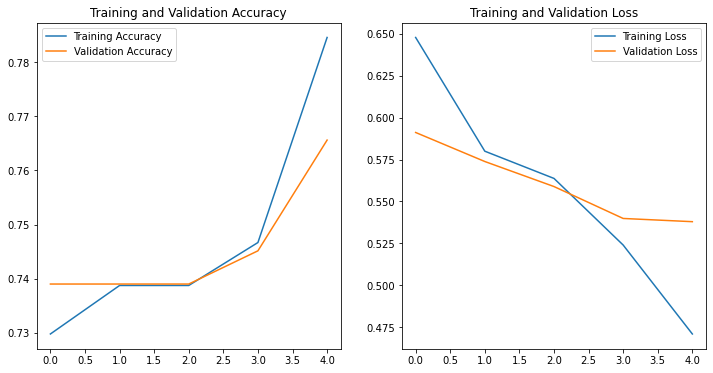

In [81]:
plot_history(history)

In [82]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
import matplotlib.pyplot as plt677
import seaborn as sns

# Vectorize the training data
vectorizer = CountVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
x_val_vec = vectorizer.transform(x_val)

# Encode labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

# Convert the encoded labels to categorical for the RNN
y_train_categorical = tf.keras.utils.to_categorical(y_train_encoded)
y_val_categorical = tf.keras.utils.to_categorical(y_val_encoded)

Naive Bayes Model Accuracy: 0.8034800409416581


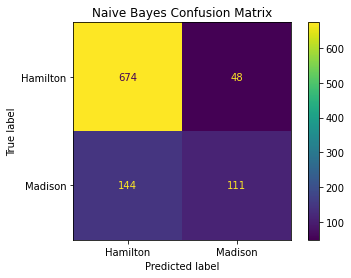

In [83]:
# Create and train the Naive Bayes model
nb_model = MultinomialNB()
nb_model.fit(X_train_vec, y_train_encoded)

# Evaluate the model on the validation data
nb_score = nb_model.score(x_val_vec, y_val_encoded)
print(f'Naive Bayes Model Accuracy: {nb_score}')

# Predictions for Naive Bayes
nb_predictions = nb_model.predict(x_val_vec)

# Confusion Matrix for Naive Bayes
nb_cm = confusion_matrix(y_val_encoded, nb_predictions)
nb_cm_display = ConfusionMatrixDisplay(nb_cm, display_labels=label_encoder.classes_).plot()
plt.title('Naive Bayes Confusion Matrix')
plt.show()


31/31 [==============================] - 2s 10ms/step


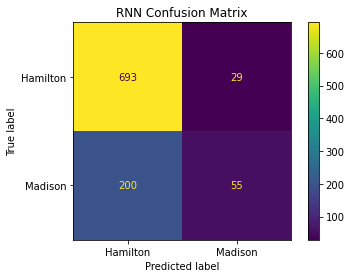

In [84]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predictions for RNN
rnn_predictions = model.predict(x_val)
rnn_predictions = np.round(rnn_predictions).astype(int)  # Convert probabilities to binary values (0 or 1)

# Confusion Matrix for RNN
rnn_cm = confusion_matrix(y_val_le, rnn_predictions)
rnn_cm_display = ConfusionMatrixDisplay(rnn_cm, display_labels=class_names).plot()
plt.title('RNN Confusion Matrix')
plt.show()